## Relative performance

* If the test set is small then the variability of the test error might be larger than the actual difference between two models. 
* To sidestep this issue we can estimate the relative performance using a large amount of unlabelled data   

See the notebook [relative_performance.ipynb](./tutorials/relative_performance.ipynb) for theoretical background. 


In [1]:
%config IPCompleter.greedy=True

In [1]:
import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

from tqdm.notebook import trange
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression

from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Experiment setup

We are going to estimate which of two models performs better using only a small set of data points which we have to label.
We  compare this with the standard setup where we estimate absolute performance of models on a large test set to see how well the relative performance evaluation really works. 
For simplicity, we use logistic regression as way to train models.  

* We generate data that satisfies a simple relation $y=x_1$ with probability $\alpha$ and $y=\neg x_1$ with probability $1-\alpha$.
* By varying the $\alpha$ over the range $[0, 0.5]$ we can create learning tasks with different complexity.

In [2]:
def sampler(n:int, k:int, alpha) -> DataFrame:
    columns = ['x_{}'.format(num) for num in range(1, k + 1)]
    return (DataFrame(random.rand(n, k), columns = columns)
            .transform(lambda x: x >= 0.5)
            .assign(y = lambda df: df['x_1'] ^ (np.random.random(n) < alpha)))

Let us first study how does the test and training error change so that we can get an idea which models to choose. 
* We aim for 80% maximal accuracy level.
* The training set size should be large enough so that logistic regression converges to optimal.
* The test set should be small enough (1000) that the test error fluctuates a lot.  

  0%|          | 0/99 [00:00<?, ?it/s]

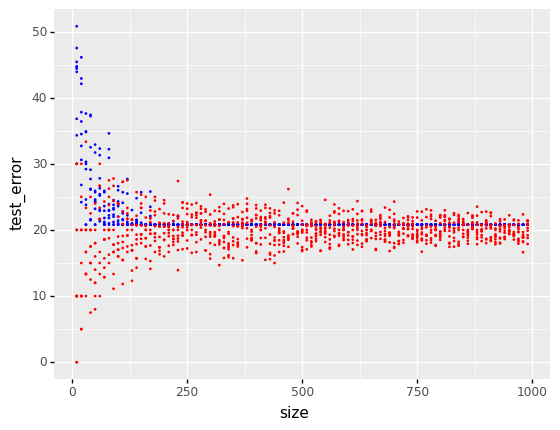

<ggplot: (351826884)>

In [5]:
k = 8
r = 10
alpha = 0.8
sizes = list(range(10, 1000, 10))
clf_1 = LogisticRegression(solver = 'lbfgs')
features =['x_{}'.format(i+1) for i in range(k)]
test_set = sampler(1000, k, alpha)

results = (combine_categories({'size': sizes,  'experiment': list(range(r))})
           .assign(test_error=np.nan)
           .assign(training_error=np.nan)
           .set_index(['size', 'experiment']))

for size in tqdm(sizes):
    for exp in range(r):
        training_set = sampler(size, k, alpha)
        clf_1.fit(training_set[features], training_set['y'])
        results.loc[(size, exp),'test_error'] = empirical_risk(clf_1, test_set[features], test_set['y'])
        results.loc[(size, exp),'training_error'] = empirical_risk(clf_1, training_set[features], training_set['y'])
    
# display(head(results))

p = ggplot(results.reset_index()) 
p = p + geom_point(aes(x='size', y='test_error'), color='blue', size=0.1)
p = p + geom_point(aes(x='size', y='training_error'), color='red', size=0.1)
display(p)

* We can clearly see that with 400 datapoints in training the logistic regression algorithm is converged.  
* However it is not clear whether there is a difference if we use  250 or 500 for training. 

## II. Relative performance estimation

# Homeworks

## 10.1 Analysis of prediction stability (<font color='red'>2p</font>)

Define two learning problems one for logistic regression and one for majority voting such that the training size is 500 datapoints and the test error is on average 20% over all possible training sets (<font color='red'>1p</font>).
* For that you should choose right value for the complexity parameter $\alpha$. 
* You can solve it by visualising the behaviour of test error as function of $\alpha$.

After that sample two training sets and train two classifiers and compare their behaviour on the test set (<font color='red'>1p</font>). 
* For that compute the percentage of datapoints where they agree and [Cohen's kappa score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html). 
* Repeat this experiment 50 times and visualise coherence score variation. 
* You should get one figure for logistic regression and one figure for majority voting. 
* Interpret the results.
  